# Parkinson's Disease Progression Prediction with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the AMP®-Parkinson's Disease Progression Prediction dataset made available for this competition. The model must predict MDS-UPDR scores, which measure progression in patients with Parkinson's disease. 

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

This notebook will also show how to do some pre-processing of the data to make it easier for an ML models to learn from it.

You'll also learn how to implement and use the evaluation metric used on this competition: SMAPE.

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the Required Libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow v" + tf.__version__)

TensorFlow Decision Forests v1.2.0
TensorFlow v2.11.0


# Load the Dataset

In [3]:
# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

In [4]:
print('clinical dataset shape:  ', train_clinical.shape)

clinical dataset shape:   (2615, 8)


In [5]:
# Display the first 5 examples
train_clinical.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [6]:
print('proteins dataset shape:  ', train_proteins.shape)

proteins dataset shape:   (232741, 5)


In [7]:
# Display the first 5 examples
train_proteins.visit_id.nunique()

1113

In [8]:
train_proteins[train_proteins['visit_id'] == '55_0'].patient_id.nunique()

1

In [9]:
print('peptides dataset shape:  ', train_peptides.shape)

peptides dataset shape:   (981834, 6)


The **train_peptides** data is composed of ***6* columns** and ***981834* entries**. We can see all 6 dimensions of our dataset by printing out the first 5 entries using the following code:

In [10]:
# Display the first 5 examples
train_peptides.head(5)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


# clinical data

In [11]:
train_clinical["patient_id"].nunique()

248

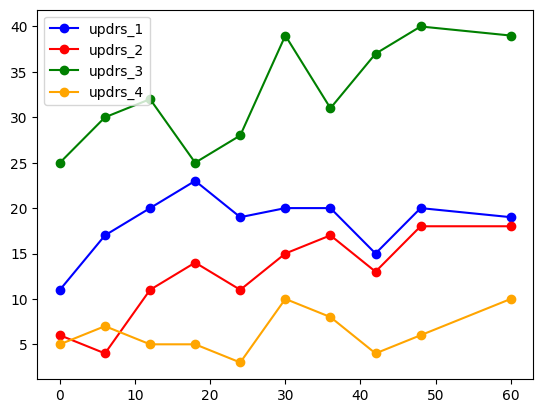

In [12]:
# Fetch data for patient with id 1517
plot_df = train_clinical[train_clinical["patient_id"]==1517]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="blue", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="red", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="green", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="orange", label="updrs_4", linestyle="-")

ax.legend()
plt.show()

# protein data

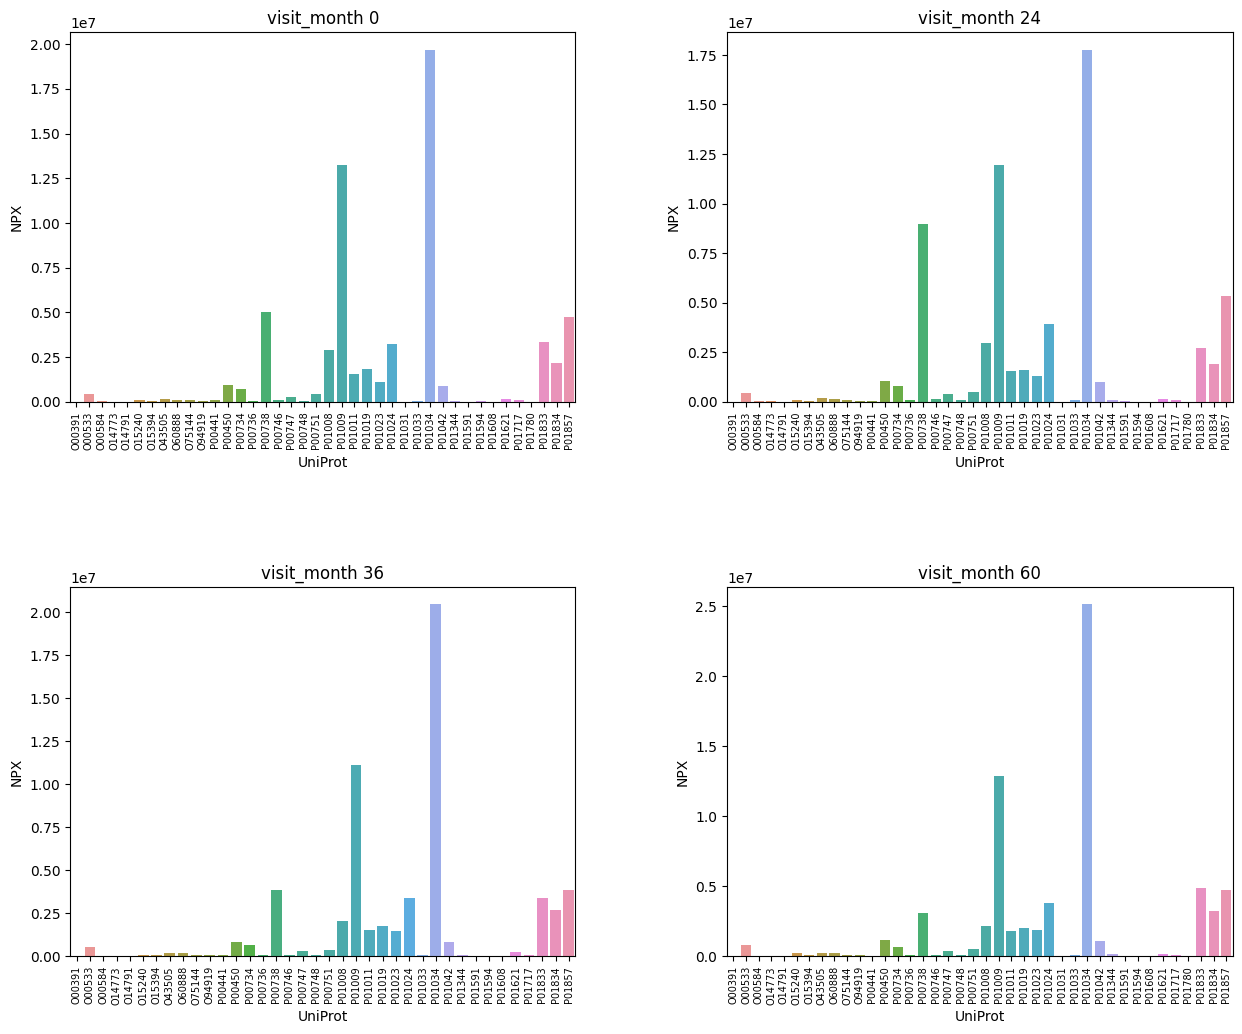

In [13]:
pro_plot_df = train_proteins[train_proteins["patient_id"]==1517]
protein_list = pro_plot_df['UniProt'].unique()
protein_list = protein_list[:40]
pro_plot_df = pro_plot_df[pro_plot_df['UniProt'].isin(protein_list)]
unique_month = pro_plot_df['visit_month'].unique()
unique_month.sort()
p_len = len(unique_month)

pro_plot_df['visit_month'].unique()
n_rows = math.ceil(p_len/2)
figure, axis = plt.subplots(n_rows, 2, figsize=(15, n_rows*6))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, month in enumerate(unique_month):
    row = i//2
    col = i % 2
    plot_df = pro_plot_df[pro_plot_df['visit_month']==month]
    bp = sns.barplot(ax=axis[row, col], x=plot_df['UniProt'], y=plot_df['NPX'])
    #bp.set(xticklabels=[])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title('visit_month ' + str(month))
plt.show()

# Data Preparation

In [14]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df

In [15]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

# EDA

In [16]:
pro_pep_df.shape

(1113, 1196)

In [17]:
# Display the first 5 examples
pro_pep_df.head(5)

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [18]:
pro_pep_df.describe()

,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,O60888,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
count,764.000000,1.112000e+03,1100.000000,1032.000000,1047.000000,942.000000,1113.000000,1050.000000,1110.000000,1079.000000,...,1100.000000,994.000000,1.022000e+03,977.000000,1.091000e+03,1111.000000,1089.000000,1105.000000,1030.000000,865.00000
mean,11641.264435,5.111649e+05,26505.529157,27305.934884,17688.295406,3004.990691,126151.780054,50773.474638,195599.363694,145382.047368,...,215246.833636,9015.134433,3.937256e+06,67866.452927,6.110779e+05,92581.223041,125937.993436,471554.596652,47068.709311,21072.04823
std,2817.003530,2.357357e+05,10705.152540,8446.187506,7166.325369,1142.159575,72748.393517,21382.028764,79739.704279,58028.089713,...,50727.227704,3127.061637,1.677710e+06,61176.002825,5.047422e+05,30138.957433,38696.448657,131150.715245,13689.667117,10360.59380
min,873.778000,5.971820e+04,591.103000,8945.340000,2811.120000,336.517000,10717.400000,5806.840000,29740.900000,8358.080000,...,12164.300000,258.249000,1.624640e+05,884.260000,7.494660e+03,869.898000,991.452000,11371.200000,6362.490000,868.90300
25%,9736.857500,3.490590e+05,19941.075000,21123.650000,12920.050000,2189.087500,70560.600000,37008.975000,142054.500000,103983.000000,...,186658.250000,6899.805000,2.895622e+06,30997.900000,2.929505e+05,70508.150000,100691.000000,384902.000000,37752.375000,14249.90000
50%,11546.400000,4.834425e+05,26529.700000,26624.000000,17399.600000,2865.460000,116900.000000,50375.800000,185616.000000,136452.000000,...,217430.500000,8604.345000,3.671010e+06,52576.900000,4.702450e+05,88918.600000,123588.000000,463382.000000,45503.150000,20390.90000
75%,13383.025000,6.485572e+05,33222.800000,32459.275000,22077.050000,3593.147500,164947.000000,63446.700000,239731.500000,177451.000000,...,246423.500000,10612.775000,4.710635e+06,85369.600000,7.592380e+05,110140.000000,149597.000000,549455.000000,54748.350000,27031.90000
max,21361.800000,1.806980e+06,66252.400000,65347.900000,49695.600000,9352.640000,538862.000000,137369.000000,766591.000000,427084.000000,...,409939.000000,27670.500000,1.385550e+07,712856.000000,3.984710e+06,251526.000000,264224.000000,948416.000000,107220.000000,70020.80000


In [19]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [20]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# sMAPE

In [21]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Training

In [22]:
# Create an empty dictionary to store the models trained for each label.
model_dict = {}

# Create an empty dictionary to store the mse score of the models trained for each label.
mse_dict = {}

# Create an empty dictionary to store the sMAPE scores of the models trained for each label.
smape_dict = {}

Next, we will create a feature list with names of the columns we will use for training the model. We will avoid the column `visit_id` and add column the `visit_month`

In [23]:
FEATURES = [i for i in pro_pep_df.columns if i not in ["visit_id"]]
FEATURES.append("visit_month")

Now let us train the models.

In [24]:
from sklearn.impute import SimpleImputer

# Define the imputer strategy
imputer = SimpleImputer(strategy='mean')

In [25]:
def calculate_smape(actual, predicted):
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)
  
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# List of target labels to loop through and train models
target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
evaluation_dict = {}
# Loop through each label   
for label in target:
    
    # Merge the label 'visit_id', 'patient_id', 'visit_month' and label columns from `train_clinical` 
    # data frame to `pro_prep_df` data frame on the `visit_id` column.
    dataset_df = pro_pep_df.merge(train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on = ['visit_id'], how = 'left')
    

#     print(dataset_df.isna().sum())
    
    # Drop null value label rows
    dataset_df = dataset_df.dropna(subset=[label])
    
    # Fit the imputer on the subset of features and transform
    X_imputed = imputer.fit_transform(dataset_df)

    # Concatenate the imputed features and the label back into a dataframe
    dataset_df = pd.DataFrame(X_imputed, columns=dataset_df.columns)
    dataset_df = dataset_df.drop_duplicates()
#     print(dataset_df.isna().sum())
        
    # Make a new copy of the FEATURES list we created previously. Add `label` to it.
    feature_list = FEATURES.copy() 
    feature_list.append(label)
    
    # Split the dataset into train and validation datasets.
    train_df, valid_df = split_dataset(dataset_df[feature_list])
    print("{} examples in training, {} examples in testing.".format(len(train_df), len(valid_df)))
    
    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task = tfdf.keras.Task.REGRESSION)
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label, task = tfdf.keras.Task.REGRESSION)
    
    # We will now create the Random Forest Tree Model with default settings. 
    # By default the model is set to train for a classification task. Since this is a regression problem,
    # we will specify the type of the task (tfdf.keras.Task.REGRESSION) as a parameter here.
    rf = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])
    
    # Train the model.
    rf.fit(x=train_ds)
    
    # Store the model
    model_dict[label] = rf

    # Evaluate the trained model on the validation dataset and store the 
    # mse value in the `mse_dict`.
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    mse_dict[label] = evaluation["mse"]  
    
    # Use the trained model to make predictions on the validation dataset.
    # Using these predictions, calculate and store the sMAPE value for this model.
    preds = rf.predict(valid_ds)
    smape_dict[label] = smape(valid_df[label].values.tolist(), preds.flatten())
    
    # Calculate evaluation metrics
    mse = mean_squared_error(valid_df[label].values.tolist(), preds.flatten())
    mae = mean_absolute_error(valid_df[label].values.tolist(), preds.flatten())
    r2 = r2_score(valid_df[label].values.tolist(), preds.flatten())
    smape1 = calculate_smape(valid_df[label].values.tolist(), preds.flatten())
    
    evaluation_dict[label] = {'mse': mse, 'smape' :smape1, 'mae': mae, 'r2': r2}
    print(label)
    print(evaluation_dict[label])

859 examples in training, 209 examples in testing.


[INFO 2023-10-05T16:14:23.809105258+00:00 kernel.cc:1214] Loading model from path /tmp/tmp__mbt2di/model/ with prefix 18aeba91eaa846d1
[INFO 2023-10-05T16:14:23.81857429+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-10-05T16:14:23.819385028+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step
updrs_1
{'mse': 28.272523394727536, 'smape': 63.17, 'mae': 3.90255130991411, 'r2': 0.05471155083999124}
872 examples in training, 196 examples in testing.


[INFO 2023-10-05T16:16:38.215598532+00:00 kernel.cc:1214] Loading model from path /tmp/tmpr_2a77ln/model/ with prefix ba210977117941b4
[INFO 2023-10-05T16:16:38.262624106+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-10-05T16:16:38.263547557+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
updrs_2
{'mse': 30.964293578654736, 'smape': 104.4, 'mae': 4.294338991751476, 'r2': 0.2176091874170184}
852 examples in training, 206 examples in testing.


[INFO 2023-10-05T16:18:23.637308336+00:00 kernel.cc:1214] Loading model from path /tmp/tmpj6dqcf9c/model/ with prefix d2094b7342fb40ae
[INFO 2023-10-05T16:18:23.672179591+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-10-05T16:18:23.673072869+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
updrs_3
{'mse': 143.77755865477087, 'smape': 84.64, 'mae': 9.611705229120346, 'r2': 0.25415776794970657}
467 examples in training, 102 examples in testing.


[INFO 2023-10-05T16:19:06.346567192+00:00 kernel.cc:1214] Loading model from path /tmp/tmp5mxb615j/model/ with prefix 721d383abd33491e
[INFO 2023-10-05T16:19:06.350114149+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2023-10-05T16:19:06.350532996+00:00 kernel.cc:1046] Use fast generic engine


1/1 [==============================] - 2s 2s/step
updrs_4
{'mse': 10.04874397199045, 'smape': 156.67, 'mae': 2.385760638059354, 'r2': 0.00047676047507438923}


# Inspect the Mean Squared Error(MSE) scores of the models.

In [27]:
for name, value in mse_dict.items():
  print(f"label {name}: mse {value:.4f}")

print("\nAverage mse", sum(mse_dict.values())/4)

label updrs_1: mse 28.2725
label updrs_2: mse 30.9643
label updrs_3: mse 143.7776
label updrs_4: mse 10.0487

Average mse 53.265780210494995


# Inspect the sMAPE scores of the models

In [28]:
for name, value in smape_dict.items():
  print(f"label {name}: sMAPE {value:.4f}")

print("\nAverage sMAPE", sum(smape_dict.values())/4)

label updrs_1: sMAPE 63.1725
label updrs_2: sMAPE 104.3972
label updrs_3: sMAPE 84.6438
label updrs_4: sMAPE 156.6729

Average sMAPE 102.22161490782298


# Visualize the model

In [29]:
# Let us use the model for the label `updrs_1` for this purpose
tfdf.model_plotter.plot_model_in_colab(model_dict['updrs_1'], tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

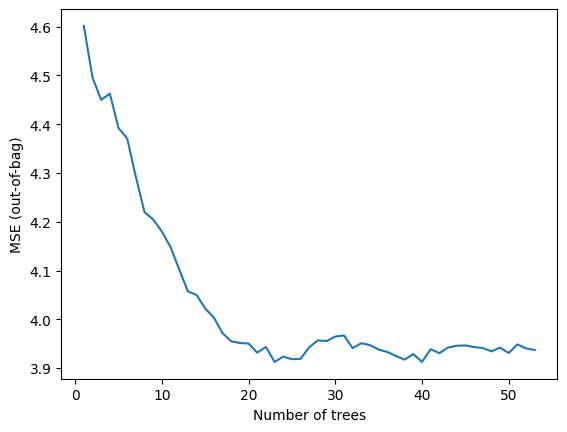

In [30]:
import matplotlib.pyplot as plt

# Let us use the model for the label `updrs_1` for this purpose
logs = model_dict['updrs_1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("MSE (out-of-bag)")
plt.show()

In [31]:
# Let us use the model for the label `updrs_1` for this purpose
inspector = model_dict['updrs_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


In [32]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("Q6UXB8" (1; #829), 5.0),
 ("P04180" (1; #703), 4.0),
 ("P05067" (1; #713), 4.0),
 ("P05060" (1; #712), 2.0),
 ("EVQPVELPNC(UniMod_4)NLVK" (1; #219), 1.0),
 ("LGPLVEQGRVR" (1; #493), 1.0),
 ("O60888" (1; #638), 1.0),
 ("P61916" (1; #801), 1.0),
 ("Q06481" (1; #810), 1.0),
 ("TQSSLVPALTDFVR" (1; #1060), 1.0),
 ("VVEESELAR" (1; #1146), 1.0),
 ("YFIDFVAR" (1; #1166), 1.0)]

# Submission

In [33]:
import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [34]:
def get_predictions(test_df, test_ds, model_dict):

    # Target labels
    target = ["updrs_1", "updrs_2", "updrs_3", "updrs_4"]
    temp = test_df[FEATURES].copy()
    
    # Filter out all the 0 value columns before predicting
    mask = test_df[FEATURES].sum(axis=1) != 0
    new_test_df = temp.loc[mask]
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(new_test_df, task = tfdf.keras.Task.REGRESSION)
    for u in target:
        test_df['result_' + str(u)] = 0
        if u != 'updrs_4':
            print(model_dict[u])
            test_df.loc[mask, 'result_' + str(u)] = model_dict[u].predict(test_ds)
    
    # Format for final submission
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:

            temp = test_df[["visit_id", "result_updrs_" + str(u)]].copy()
            temp["prediction_id"] = temp["visit_id"] + "_updrs_" + str(u) + "_plus_" + str(m) + "_months"
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)            
    result = result.drop_duplicates(subset=['prediction_id', 'rating'])

    return result

In [35]:
# Reference: https://www.kaggle.com/code/xarispanagiotopoulos/linearregression-xgb/notebook

for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    pro_pep_df = prepare_dataset(test_proteins, test_peptides)


    test_proteins = test_proteins.pivot(index=['visit_id', 'visit_month', 'patient_id'], 
              columns='UniProt', values='NPX').reset_index().rename_axis(None, axis=1).drop(columns=['visit_month', 'patient_id'])
    merged_df = test.merge(test_proteins, how='left', on='visit_id')

    test_df = test.merge(pro_pep_df, how='left', on='visit_id')
    
    # Add all the missing columns from FEATURES list and set the values as 0
    for col in FEATURES:
        if col not in test_df.columns:
            test_df[col] = 0
    test_df = test_df[['visit_id', 'patient_id'] + FEATURES]

    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, task = tfdf.keras.Task.REGRESSION)
    result = get_predictions(test_df, valid_ds, model_dict)
    print(result)

    env.predict(result)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 7s 7s/step
                    prediction_id     rating
0    3342_0_updrs_1_plus_0_months   0.000000
4   50423_0_updrs_1_plus_0_months   9.972058
0    3342_0_updrs_2_plus_0_months   0.000000
4   50423_0_updrs_2_plus_0_months   8.904767
0    3342_0_updrs_3_plus_0_months   0.000000
4   50423_0_updrs_3_plus_0_months  34.586349
0    3342_0_updrs_4_plus_0_months   0.000000
4   50423_0_updrs_4_plus_0_months   0.000000
0    3342_0_updrs_1_plus_6_months   0.000000
4   50423_0_updrs_1_plus_6_months   9.972058
0    3342_0_updrs_2_plus_6_months   0.000000
4   50423_0_updrs_2_plus_6_months   8.904767
0    3342_0_updrs_3_plus_6_months   0.000000
4   50423_0_updrs_3_plus_6_months  34.586349
0    3342_0_updrs_4_plus_6_months   0.000000
4   50423_0_updrs_4_plus_6_months   0.000000
0   3342_0_updrs_1_plus_12_months   0.000000
4  50423_0_updr

/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)


1/1 [==============================] - 7s 7s/step
                    prediction_id     rating
0    3342_6_updrs_1_plus_0_months   4.208898
4   50423_6_updrs_1_plus_0_months   4.572544
0    3342_6_updrs_2_plus_0_months   4.028201
4   50423_6_updrs_2_plus_0_months   2.928040
0    3342_6_updrs_3_plus_0_months  14.899885
4   50423_6_updrs_3_plus_0_months  16.600996
0    3342_6_updrs_4_plus_0_months   0.000000
4   50423_6_updrs_4_plus_0_months   0.000000
0    3342_6_updrs_1_plus_6_months   4.208898
4   50423_6_updrs_1_plus_6_months   4.572544
0    3342_6_updrs_2_plus_6_months   4.028201
4   50423_6_updrs_2_plus_6_months   2.928040
0    3342_6_updrs_3_plus_6_months  14.899885
4   50423_6_updrs_3_plus_6_months  16.600996
0    3342_6_updrs_4_plus_6_months   0.000000
4   50423_6_updrs_4_plus_6_months   0.000000
0   3342_6_updrs_1_plus_12_months   4.208898
4  50423_6_updrs_1_plus_12_months   4.572544
0   3342_6_updrs_2_plus_12_months   4.028201
4  50423_6_updrs_2_plus_12_months   2.928040
0   3

/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
/tmp/ipykernel_34/2111800362.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(temp)
